In [1]:
import numpy as np
import os, pickle
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.ndimage import gaussian_filter
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

from src.model import intensity
from src.theory import rate_fn, rate_fn_neg
from src.sim import sim_lif_perturbation, sim_lif_perturbation_x, sim_lif_pop, create_spike_train
from src.phase_plane import dv, phase_plane_plot

In [2]:
from scripts import plot_fluctuations

from scripts.plot_exc_inh import *
from scripts.plot_uncoupled import *

c:\Users\Mateo\Documents\BU\ocker group\lif_stochastic_decision\scripts\plot_exc_inh.py:94: RuntimeWarning: divide by zero encountered in divide
  gbound_mft = (-2 + J)/J - 2*np.sqrt((1-E))/J
c:\Users\Mateo\Documents\BU\ocker group\lif_stochastic_decision\scripts\plot_exc_inh.py:97: RuntimeWarning: divide by zero encountered in divide
  gbound_1loop = -np.sqrt(5) * np.sqrt((1-E))/J + (-9+4*J)/(4*J)


(250,)
(250,)


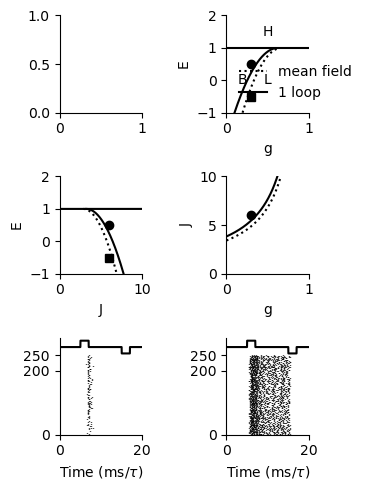

In [3]:
plot_fig_exc_inh_weakly_coupled()

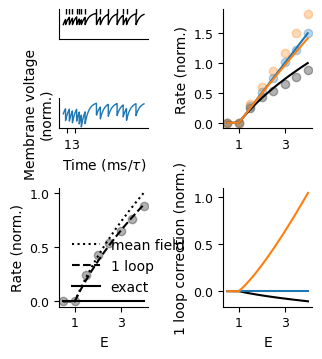

In [4]:
plot_fig_intro_uncoupled()